In [1]:
import torch
from diffusers import StableDiffusion3Pipeline

/users/gmongaras/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-04 19:42:53.811254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-04 19:42:54.631959: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /users/gmongaras/cuda-11.8/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/users/gmongaras/miniconda3/lib/python3.10/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /hpc/mp/apps/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.4.1+cu121 with CUDA 1201 (you have 2.5.0+cu118)
    Python  3.10.15 (you have 3.10.11)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [2]:
# Read token from .env file
with open(".env", "r") as f:
    token = f.read().strip()

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16, cache_dir="./cache", token=token)
pipe = pipe.to("cuda")

Loading pipeline components...: 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


In [6]:
old_processor = pipe.transformer.transformer_blocks[0].attn.processor.__class__

In [40]:
# Reimport attention processor
import CustomProcessor as CustomProcessor
import importlib
importlib.reload(CustomProcessor)
CustomProcessor = CustomProcessor.CustomProcessor

In [41]:
# Get stable diffusion 3 config
config = pipe.transformer.config

# Replace attention in stable diffusion with the imported one
num_skip = 10
for i, layer in enumerate(pipe.transformer.transformer_blocks):
    if i < num_skip:
        layer.attn.set_processor(old_processor())
    elif i >= num_skip:
        layer.attn.set_processor(CustomProcessor())

100%|██████████| 28/28 [00:04<00:00,  6.97it/s]


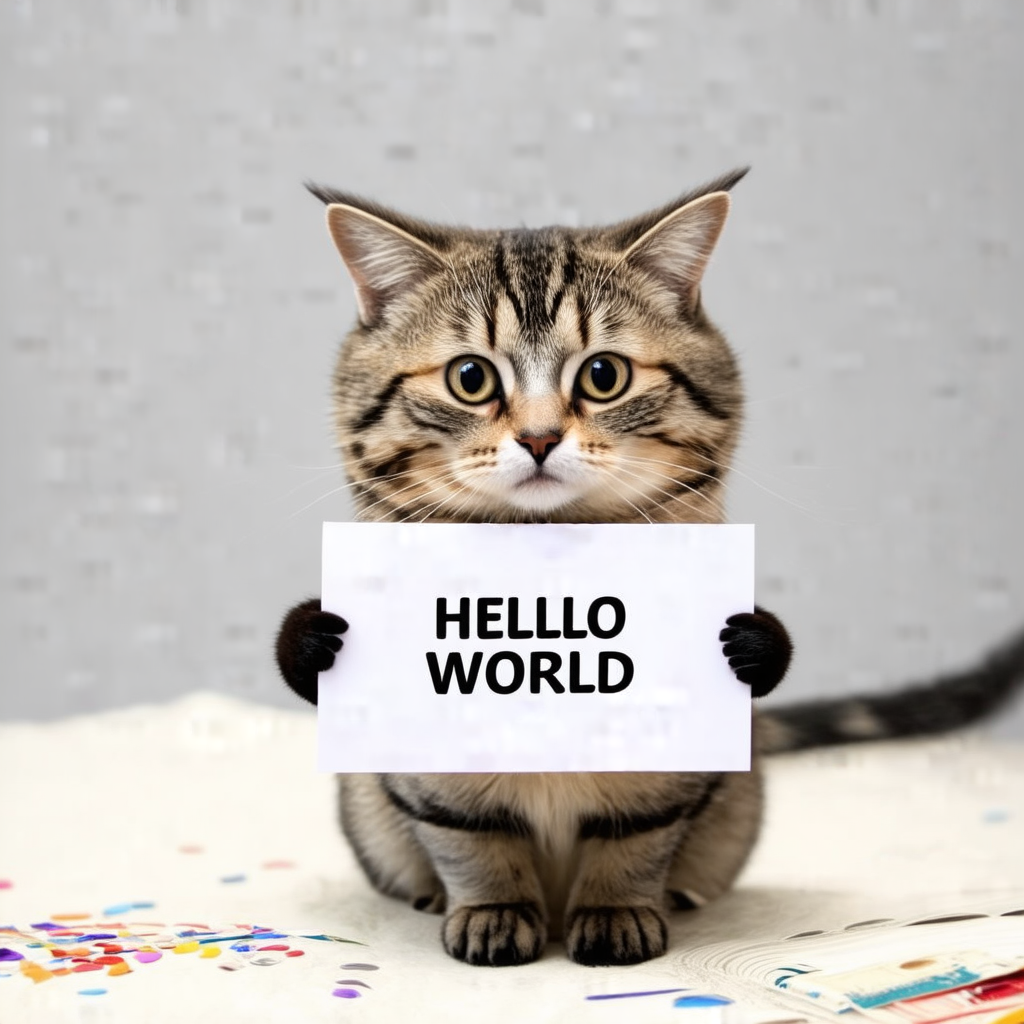

In [42]:
generator = torch.Generator(device="cpu").manual_seed(0)
image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    generator=generator
).images[0]
image

In [6]:
# # Reimport attention
# import Attention as Attention
# import importlib
# importlib.reload(Attention)
# Attention = Attention.Attention

In [7]:
# # Get stable diffusion 3 config
# config = pipe.transformer.config

# # Replace attention in stable diffusion with the imported one
# for layer in pipe.transformer.transformer_blocks:
#     old = layer.attn
#     layer.attn = Attention(
#         query_dim = old.query_dim,
#         cross_attention_dim = old.cross_attention_dim,
#         heads = old.heads,
#         kv_heads = None,
#         dim_head = 64,
#         dropout = old.dropout,
#         bias = old.use_bias,
#         upcast_attention = old.upcast_attention,
#         upcast_softmax = old.upcast_softmax,
#         cross_attention_norm = None,
#         cross_attention_norm_num_groups = 32,
#         qk_norm = None,
#         added_kv_proj_dim = old.added_kv_proj_dim,
#         added_proj_bias = old.added_proj_bias,
#         norm_num_groups = None,
#         spatial_norm_dim = None,
#         out_bias = True,
#         scale_qk = old.scale_qk,
#         only_cross_attention = old.only_cross_attention,
#         eps = 1e-5,
#         rescale_output_factor = old.rescale_output_factor,
#         residual_connection = old.residual_connection,
#         _from_deprecated_attn_block = old._from_deprecated_attn_block,
#         processor = old.processor,
#         out_dim = old.out_dim,
#         context_pre_only = old.context_pre_only,
#         pre_only = old.pre_only,
#         elementwise_affine = True,
#     ).to(old.to_k.weight.device).to(old.to_k.weight.dtype)
#     layer.attn.load_state_dict(old.state_dict())
#     del old

  0%|          | 0/28 [02:07<?, ?it/s]


KeyboardInterrupt: 